### Read in data

In [2]:
# import packages 
import os
from toolz import pipe
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# paths and filenames 
path = os.getcwd()
path_images = path + "\\test_images\\"
file_names = os.listdir(path_images)
print("Total files in dir: {0}".format(len(file_names)))

Total files in dir: 1


In [4]:
# read in the first image from the list of files
ret, image = cv2.imreadmulti(path_images+file_names[0], [], cv2.IMREAD_UNCHANGED)
print("Total slices in stack: {0}".format(len(image)))

Total slices in stack: 8


### Pick a skeletonised slice 

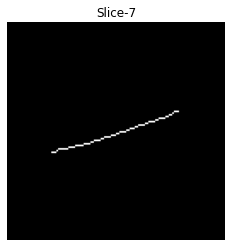

In [5]:
# working wth the seventh slice of this image
img = image[6]
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("Slice-7");

### Hough transform

A straight line parametrised with polar coordinates becomes:  
$$y = \frac{-\cos(\theta)}{\sin(\theta)} x + \frac{\rho}{\sin(\theta)}$$ 
since  
$$\rho = x\ \cos(\theta) + y\ \sin(\theta)$$

In [6]:
# initialise parameter space of all rhos and thetas
n_y, n_x = img.shape[:]
diag = int(np.sqrt(n_x**2 + n_y**2))

# rhos range from -diagnoal to +diagonal of image 
rhos = np.linspace(-diag, diag, 2*diag+1)
n_rhos = len(rhos)

# thetas range from [0, pi] or [-90, 90] radians
#thetas = np.deg2rad(np.arange(-90, 90))
thetas = np.deg2rad(np.arange(0, 180))
cos_theta = np.cos(thetas)
sin_theta = np.sin(thetas)
n_thetas = len(thetas)

# loop through line pixels 
### in this case we know exactly which pixels in fact belong to a line
nonzeros = np.argwhere(img==255)
## scaling nonzeroes - does not make a lot of sense though
#nonzeros_scaled = nonzeros - np.array([[n_y/2, n_x/2]])

In [7]:
# Hough transform: get rho results 
x = np.array(nonzeros[:,1])
y = np.array(nonzeros[:,0])
n_xys = nonzeros.shape[0]

theta_mult = np.tile(thetas, n_xys).reshape((n_xys, n_thetas))
cos_theta_mat = np.cos(theta_mult)
sin_theta_mat = np.sin(theta_mult)
#rhos_res = np.mat(x)*np.mat(np.cos(theta_mult)) + np.mat(y)*np.mat(np.sin(theta_mult))
rhos_res = (x.reshape(n_xys,1)*cos_theta_mat) + (y.reshape(n_xys,1)*sin_theta_mat)
### scaling rhos 
#rhos_res = rhos_res+diag

In [8]:
# get frequency of each (theta, rho) pair   
## theta vals == thetas 
## but rho_vals ranges from min(rho_res) to max(rho_res)
accumulator = np.zeros((n_rhos, n_rhos))
accumulator, theta_vals, rho_vals = np.histogram2d(
    np.tile(thetas, rhos_res.shape[0]),
    rhos_res.ravel(),
    bins = [n_thetas, n_rhos-1], ## when specifying n_bins, if n_thetas is n_thetas-1, thetas are off 
    range = [np.deg2rad([0,180]), [-diag, diag]])

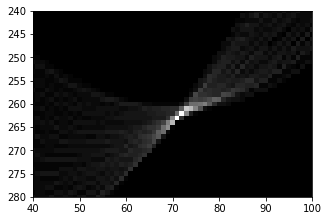

In [9]:
# plot part of accumulator
plt.figure(figsize = (5,5))
plt.imshow(np.transpose(accumulator), cmap="gray");
plt.xlim(40,100)
plt.ylim(280, 240);

In [10]:
# look at accumulator near maximum
accumulator[64:78,256:269]

array([[ 0.,  0.,  0.,  0.,  2.,  6.,  4.,  4.,  4.,  7.,  6.,  9.,  8.],
       [ 0.,  0.,  0.,  0.,  2.,  5.,  5.,  4.,  5.,  9.,  7., 10.,  9.],
       [ 0.,  0.,  0.,  0.,  1.,  6.,  5.,  5.,  7.,  9., 10., 13., 13.],
       [ 0.,  0.,  0.,  0.,  1.,  6.,  6.,  5.,  9., 11., 17., 16.,  4.],
       [ 0.,  0.,  0.,  0.,  1.,  7.,  6.,  5., 12., 20., 20.,  4.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  7.,  7.,  9., 23., 26.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  8.,  7., 24., 34.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  8., 19., 47.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  3., 17., 46.,  9.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  3., 11., 37., 24.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  3., 11., 20., 34.,  6.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  3., 13., 12., 20., 24.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 4., 11.,  9., 11., 21., 15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [11.,  7.,  9., 12., 23.,  3., 

In [11]:
# index of maximum in accumulator
ind = np.argwhere(accumulator==np.max(accumulator))[0]
print("Rho = ", rho_vals[ind[1]])
print("Theta = ", theta_vals[ind[0]])
print("Min = ", ind)

Rho =  82.0
Theta =  1.239183768915974
Min =  [ 71 263]


In [12]:
# index of maximum in accumulator - manual
# not working properly
i = np.argmax(accumulator)
x = int(i/363)
y = int(i % 363) 
print(x, y)
print(rho_vals[y])
print("i = ", i, "   ind = ", ind)

71 192
11.0
i =  25965    ind =  [ 71 263]


In [13]:
# get coordinates of line in cartesian coordinates
rho_f = rho_vals[ind[1]]
theta_f = thetas[ind[0]]
#theta_f = theta_vals[ind[0]]
cos_theta_f = np.cos(theta_f)
sin_theta_f = np.sin(theta_f)

xs = np.linspace(0, 127, 128)

intercept = rho_f/sin_theta_f
slope_x = np.array([(-cos_theta_f*xs)/sin_theta_f])

ys = slope_x+intercept

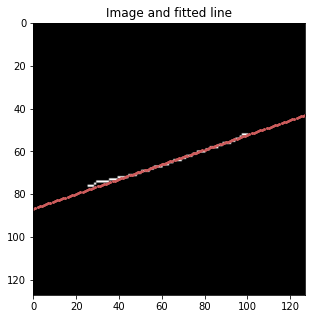

In [14]:
# overlay image with fitted line 
plt.figure(figsize=(5,5))
plt.imshow(img, cmap="gray")
x = np.array(range(128))
plt.scatter(xs, ys, c="indianred", s=4)
plt.xlim(0,127)
plt.ylim(127,0)
plt.title("Image and fitted line")
plt.show()

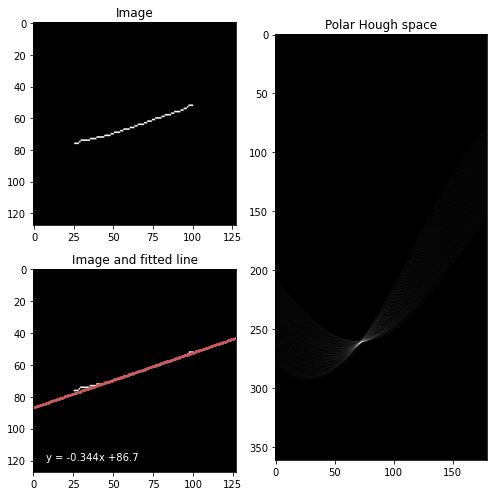

In [15]:
# plot image and pixel data side by side
fig = plt.figure(figsize=(7, 7))

fig.add_subplot(221)
plt.imshow(img, cmap="gray")
#plt.axis("off")
plt.title("Image");

fig.add_subplot(223)
plt.imshow(img, cmap="gray")
x = np.array(range(128))
plt.scatter(xs, ys, c="indianred", s=4)
plt.xlim(0,127)
plt.ylim(127,0)
plt.text(8, 120,
         ("y = " + str(np.round(-cos_theta_f/sin_theta_f, 3)) + "x +" + str(np.round(intercept, 1))),
         fontsize = 10, color = "white")
plt.title("Image and fitted line")

fig.add_subplot(122)
#plt.figure(figsize=(5,7))
plt.imshow(np.transpose(accumulator), cmap="gray");
plt.title("Polar Hough space");

plt.tight_layout()
#plt.savefig("figs\\image_fit_overlay_hough.png", format="png", dpi=600)

In [17]:
print("m = ", np.round(-cos_theta_f/sin_theta_f, 3), "    inteercept = ", np.round(intercept, 1))

m =  -0.344     inteercept =  86.7


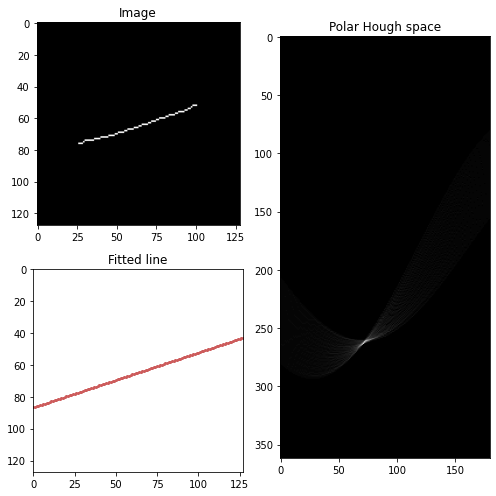

In [18]:
# plot image and pixel data side by side
fig = plt.figure(figsize=(7, 7))

fig.add_subplot(221)
plt.imshow(img, cmap="gray")
#plt.axis("off")
plt.title("Image");

fig.add_subplot(223)
plt.scatter(xs, ys, c="indianred", s=4)
plt.xlim(0,127)
#plt.ylim(0, 128);
plt.ylim(127, 0);
plt.title("Fitted line")

fig.add_subplot(122)
#plt.figure(figsize=(5,7))
plt.imshow(np.transpose(accumulator), cmap="gray");
plt.title("Polar Hough space");

plt.tight_layout()
#plt.savefig("figs\\image_hough_space_fitted_line.png", format="png", dpi=600)

In [ ]:
#np.matmul(np.transpose(np.matrix([2,2,3,3])), np.matrix([10,10,10]))

In [ ]:
#np.matmul(np.transpose(np.array([2,2,3,3])), np.array([10,10,10]))

In [ ]:
## normalise image to avoid overflow 
# normalise = (vals - min) / (max(vals - min))


### Linear regression

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
X = np.array(nonzeros[:,1]).reshape((-1,1))
Y = np.array(nonzeros[:,0])

In [23]:
model = LinearRegression().fit(X, Y)
print("R squared: ", np.round(model.score(X, Y), 4)) 

R squared:  0.9915


In [56]:
y_LR = model.predict(xs.reshape((-1, 1)))

In [26]:
# compare two fits
print("Hough transform:      m = ", np.round(-cos_theta_f/sin_theta_f, 3), 
      "    inteercept = ", np.round(intercept, 1))
print("Linear regression:    m = ", np.round(model.coef_[0], 3),
      "    inteercept = ", np.round(model.intercept_, 1))

Hough transform:      m =  -0.344     inteercept =  86.7
Linear regression:    m =  -0.324     inteercept =  85.4


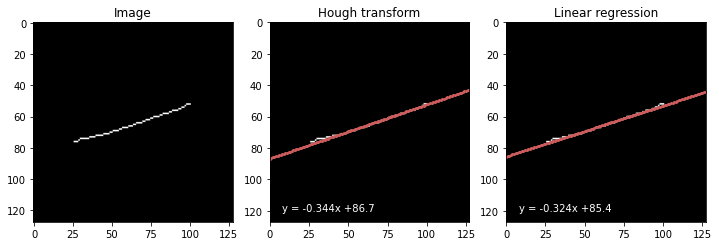

In [63]:
# plot image and pixel data side by side
fig = plt.figure(figsize=(10, 4))

# image 
fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
#plt.axis("off")
plt.title("Image");

# Hough transform result 
fig.add_subplot(1, 3, 2)
plt.imshow(img, cmap="gray")
x = np.array(range(128))
plt.scatter(xs, ys, c="indianred", s=4)
plt.xlim(0,127)
plt.ylim(127,0)
plt.text(8, 120,
         ("y = " + str(np.round(-cos_theta_f/sin_theta_f, 3)) + "x +" + str(np.round(intercept, 1))),
         fontsize = 10, color = "white")
plt.title("Hough transform")

fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap="gray")
x = np.array(range(128))
plt.scatter(xs, y_LR, c="indianred", s=4)
plt.xlim(0,127)
plt.ylim(127,0)
plt.text(8, 120,
         ("y = " + str(np.round(model.coef_[0], 3)) + "x +" + str(np.round(model.intercept_, 1))),
         fontsize = 10, color = "white")
plt.title("Linear regression")

plt.tight_layout()
#plt.savefig("figs\\Hough_transform_vs_Linear_regression.png", format="png", dpi=600)